# ECE 284 Project, Replicating research paper:
## *Understanding the ability of low-cost MOx sensors to quantify ambient VOCs*
#### By: Ashley M. Collier-Oxandale, Jacob Thorson, Hannah Halliday, Jana Milford, and Michael Hannigan

Article: https://amt.copernicus.org/articles/12/1441/2019/amt-12-1441-2019-discussion.html
Data: https://data.mendeley.com/datasets/hkn2tbcp67/1

The paper only implements linear regression, so I will first replicate the linear regression along with the plots generated by the paper, and then I will try using more advanced machine learning techniques, such as neural nets.

## Setup

In [4]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from datetime import date
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize

torch.set_default_dtype(torch.float64)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
# the .mat file has the data stored in tables, so it is necessary to run the toPython.m script first

# labels appear as 'nan' when written to array, so making it array name
labels = ['Time', 'Temp', 'RH', 'Fig1v', 'Fig2v', 'ELT', 'e2vO3', 'e2vNO2', 'AH', 'Fig1r', 'Fig2r', 'Actd', 'Acet', 
          'Benz', 'C8', 'C9', 'Form', 'Meth', 'Tol', 'CH4', 'CO', 'O3', 'NO2', 'CO2', 'T_Plat', 'RH_Plat', 'H2S', 'TimeL']
full_labels = ['Time', 'Temperature', 'Relative Humidity', 'Figaro2600 (V)', 'Figaro2602 (V)', 'NDIR CO2', 'MOx O3', 'MOx NO2',
              'Absolute Humidity', 'Figaro2600 (nR)', 'Figaro2602 (nR)', 'Acetaldehyde', 'Acetone', 'Benzene', 'C8', 'C9',
              'Formaldehyde', 'Methanol', 'Toluene', 'Methane', 'Carbon Monoxide', 'Ozone', 'Nitrogen Dioxide', 
               'Carbon Dioxide', 'Temperature (native)', 'Relative Humidity (native)', 'Hydrogen Sulfide', 'Time (local)']

PrimaryUPod = np.genfromtxt('primary.csv', skip_header=1, delimiter=',')#, names=labels) 
SecondaryUPod = np.genfromtxt('secondary.csv', skip_header=1, delimiter=',')#, names=labels[:-1])

# including the name would make it a 1D array of tuples, so I'll just define a quick function to fetch by name 
def get_column(data, label, name):
    return data[:,label.index(name)]

In [6]:
# prepare the data for the regression
p_TimeL = get_column(PrimaryUPod, labels, 'TimeL')

# defining testing and training data
beg_testing = date.toordinal(date(2014,7,20))+366 # 366 needed to match with MATLAB times
end_testing = date.toordinal(date(2014,8,5))+366
ind1   = sum(p_TimeL <= beg_testing) # use sum to find last as 'True' == 1
ind2   = sum(p_TimeL <= end_testing)
ind1_1 = range(0, ind1)    # or use [:ind1]
ind1_2 = range(ind2, 4822) # or use [ind2:]
train  = list(ind1_1) + list(ind1_2) # for concatenation needs to be in list
test2  = range(ind1, ind2) 

# create the data bactches
x_data   = np.array([PrimaryUPod[:,9], PrimaryUPod[:,10] , PrimaryUPod[:,9] * PrimaryUPod[:,10], PrimaryUPod[:,1], PrimaryUPod[:,8], PrimaryUPod[:,0]]).T
x_train  = x_data[train,:]
x_test   = x_data[test2,:]

x_data2  = np.array([PrimaryUPod[:,9], PrimaryUPod[:,10] , PrimaryUPod[:,9] * PrimaryUPod[:,10], np.square(PrimaryUPod[:,4]), PrimaryUPod[:,1], PrimaryUPod[:,8], PrimaryUPod[:,1] * PrimaryUPod[:,10], PrimaryUPod[:,0]]).T
x_train2 = x_data2[train,:]
x_test2  = x_data2[test2,:]
# data2 should have more variants for the different estimations

# data for the aromatics and VOC which are a combination of others
aromatic = 6 * get_column(PrimaryUPod, labels, 'Benz') + 7 * get_column(PrimaryUPod, labels, 'Tol') + 8 * get_column(PrimaryUPod, labels, 'C8') + 9 * get_column(PrimaryUPod, labels, 'C9');
VOC = 6 * get_column(PrimaryUPod, labels, 'Benz') + 7 * get_column(PrimaryUPod, labels, 'Tol') + 8 * get_column(PrimaryUPod, labels, 'C8') + 9 * get_column(PrimaryUPod, labels, 'C9') + get_column(PrimaryUPod, labels, 'Meth') + 3 * get_column(PrimaryUPod, labels, 'Acet') + 2 * get_column(PrimaryUPod, labels, 'Actd') + get_column(PrimaryUPod, labels, 'Form');

# create lists for storing errors
stats_rc = []
stats_ec = []

### Linear Regression Implementation

In [18]:
def linear_fit(name, auto_gen_ticks = False, residuals_paper = False):
    # Get the data from the name
    if (name == 'Aro'):
        y_train = aromatic[train]
        y_test = aromatic[test2]
        full_name = "Summed Aromatics"
        reference = aromatic
    elif (name == 'VOC'):
        y_train = VOC[train]
        y_test = VOC[test2]
        full_name = "Summed PTR-MS VOCs"
        reference = VOC
    else:
        y_train = get_column(PrimaryUPod, labels, name)[train]
        y_test = get_column(PrimaryUPod, labels, name)[test2]
        full_name = full_labels[labels.index(name)]
        reference = get_column(PrimaryUPod, labels, name)
    
    plt_ur = (int(max(y_test) / 10) + 1) * 10
    if  (name == 'Benz'):
        plt_ur = 21;
    elif (name == 'CH4'):
        plt_ur = 10;
    elif (name == 'Aro'):
        plt_ur = 250;
    elif (name == 'VOC'):
        plt_ur = 150;
    
    # General Linear Regression Models

    mdl = LinearRegression().fit(x_train, y_train)
    fitted = mdl.predict(x_train)
    predicted = mdl.predict(x_test)
    r0 = mdl.score(x_train, y_train)
    e0 = mean_squared_error(fitted, y_train, squared=False) # false for getting the RMSE
    r1 = mdl.score(x_test, y_test)
    e1 = mean_squared_error(predicted, y_test, squared=False)

    mdl2 = LinearRegression().fit(x_train2, y_train)
    fitted2 = mdl2.predict(x_train2)
    predicted2 = mdl2.predict(x_test2)
    r2 = mdl2.score(x_train2, y_train)
    e2 = mean_squared_error(fitted2, y_train, squared=False)
    r3 = mdl2.score(x_test2, y_test)
    e3 = mean_squared_error(predicted2, y_test, squared=False)


    # General Plots

    plt.plot(p_TimeL, reference, 'k', linewidth=1);
    plt.plot(p_TimeL[train], fitted, '--b', linewidth=1);
    plt.plot(p_TimeL[test2], predicted, '--r', linewidth=1);
    plt.plot(p_TimeL[train], fitted2, '--y', linewidth=1);
    plt.plot(p_TimeL[test2], predicted2, '--g', linewidth=1);
    plt.title(full_name);
    plt.xlabel('Local Time');
    plt.ylabel(full_name + ', ppb');
    plt.legend(['Reference (PTR-MS)', f'Training: $R^2$ = {round(r0,2)} , RMSE = {round(e0,2)}', 
               f'Testing: $R^2$ = {round(r1,2)} , RMSE = {round(e1,2)}',f'Training: $R^2$ = {round(r2,2)} , RMSE = {round(e2,2)}',
               f'Testing: $R^2$ = {round(r3,2)} , RMSE = {round(e3,2)}']);

    if auto_gen_ticks: # use the autogen spacing from python, else use the ones from paper
        locs, t_labels = plt.xticks()
        i = 0; date_arr = []
        for dd in locs.astype(int):
            day = date.fromordinal(dd-366)
            date_arr.append(str(day.month) + '/' + str(day.day)) # f'{day.month}/{day.day}'
            i+=1
    else:
        i = 0; locs = []
        date_arr = ['07/18', '07/20', '07/22', '07/24', '07/26', '07/28', '07/30', '08/01', '08/03', '08/05', '08/07', '08/09']
        for dd in date_arr:
            aa = dd.split('/')
            locs.append(date.toordinal(date(2014,int(aa[0]),int(aa[1])))+366)
            i+=1
    plt.xticks(locs, date_arr, fontsize = 8); # change ord number to readable date for the x-axis
    plt.axvspan(p_TimeL[0], beg_testing, color='yellow', alpha=0.15) # highlight the training data
    plt.axvspan(end_testing, p_TimeL[-1], color='yellow', alpha=0.15)
    plt.show()


    plt.scatter(predicted, y_test, c='b', marker='+')
    plt.scatter(predicted2, y_test, c='r', marker='x')
    plt.plot(range(0,plt_ur),range(0,plt_ur), '--k')
    plt.axis('square')
    plt.xlabel('Sensor data (testing)');
    plt.ylabel(full_name + ', ppb');
    plt.legend(["1:1 line", 'Mdl1', "Mdl2"])
    plt.show()


    if residuals_paper: # Residuals shown as in the paper, else split in 4 subplots
        raw_res = y_test - predicted
        raw_res2 = y_test - predicted2

        plt.figure().set_figwidth(2) # make plot thin
        plt.xlim(-0.5, 1.5)

        plt.scatter(np.zeros([len(raw_res)]), raw_res, c='k', marker='+')
        plt.scatter(np.ones([len(raw_res)]), raw_res2, c='k', marker='+')
        plt.xlabel('Residuals')
        plt.ylabel('Testing data, ppb')
        plt.xticks([0,1],['Mdl1', 'Mdl2'])

        # draw mean and 5th/95th percentile
        mean = raw_res.mean()
        mean2 = raw_res2.mean()
        p_05 = np.percentile(raw_res, 5)
        p_95 = np.percentile(raw_res, 95)
        p_052 = np.percentile(raw_res2, 5)
        p_952 = np.percentile(raw_res2, 95)
        #plt.errorbar(0, mean, std, ecolor='r', elinewidth=3, barsabove=True)
        plt.plot([-0.2, 0.2], [p_05, p_05], 'r')
        plt.plot([-0.2, 0.2], [mean, mean], 'r', linewidth=1)
        plt.plot([-0.2, 0.2], [p_95, p_95], 'r')
        plt.plot([0.8, 1.2], [p_052, p_052], 'r')
        plt.plot([0.8, 1.2], [mean2, mean2], 'r', linewidth=1)
        plt.plot([0.8, 1.2], [p_952, p_952], 'r')
        plt.show() # was fixed to be 5th and 95th percentile rather than std
    else:
        raw_res = y_train - fitted
        std_res = raw_res / np.std(raw_res)
        raw_res2 = y_train - fitted2
        std_res2 = raw_res2 / np.std(raw_res2)

        plt.subplot(2,2,1)
        plt.scatter(y_train, std_res, c = 'b', marker = '*')
        plt.scatter(y_train, std_res2, c = 'r', marker = '*')
        plt.title('Residuals vs. Concentration')
        #lsline
        m, b = np.polyfit(y_train, std_res, deg=1)
        m2, b2 = np.polyfit(y_train, std_res2, deg=1)
        plt.axline(xy1=(0, b), slope=m)
        plt.axline(xy1=(0, b2), slope=m2)

        plt.subplot(2,2,2)
        plt.scatter(get_column(PrimaryUPod, labels, 'Temp')[train], std_res, c = 'b', marker = '*')
        plt.scatter(get_column(PrimaryUPod, labels, 'Temp')[train], std_res2, c = 'r', marker = '*')
        #plt.axis('square')
        plt.title('Residuals vs. Temperature')
        #lsline
        m, b = np.polyfit(get_column(PrimaryUPod, labels, 'Temp')[train], std_res, deg=1)
        m2, b2 = np.polyfit(get_column(PrimaryUPod, labels, 'Temp')[train], std_res2, deg=1)
        plt.axline(xy1=(0, b), slope=m)
        plt.axline(xy1=(0, b2), slope=m2)

        plt.subplot(2,2,3)
        plt.scatter(get_column(PrimaryUPod, labels, 'AH')[train], std_res, c = 'b', marker = '*')
        plt.scatter(get_column(PrimaryUPod, labels, 'AH')[train], std_res2, c = 'r', marker = '*')
        #plt.axis('square')
        plt.title('Residuals vs. Absolute Humidity')
        #lsline
        m, b = np.polyfit(get_column(PrimaryUPod, labels, 'AH')[train], std_res, deg=1)
        m2, b2 = np.polyfit(get_column(PrimaryUPod, labels, 'AH')[train], std_res2, deg=1)
        plt.axline(xy1=(0, b), slope=m)
        plt.axline(xy1=(0, b2), slope=m2)
        plt.xlim(0.01, 0.02)

        plt.subplot(2,2,4)
        plt.scatter(get_column(PrimaryUPod, labels, 'Time')[train], std_res, c = 'b', marker = '*')
        plt.scatter(get_column(PrimaryUPod, labels, 'Time')[train], std_res2, c = 'r', marker = '*')
        #plt.axis('square')
        plt.title('Residuals vs. Time')
        #lsline
        m, b = np.polyfit(get_column(PrimaryUPod, labels, 'Time')[train], std_res, deg=1)
        m2, b2 = np.polyfit(get_column(PrimaryUPod, labels, 'Time')[train], std_res2, deg=1)
        plt.axline(xy1=(0, b), slope=m)
        plt.axline(xy1=(0, b2), slope=m2)
        plt.xlim(get_column(PrimaryUPod, labels, 'Time')[train][0], get_column(PrimaryUPod, labels, 'Time')[train][-1])

        plt.tight_layout()
        plt.show()
    return mdl, mdl2

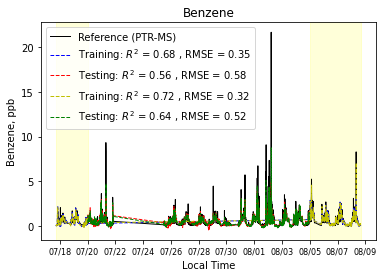

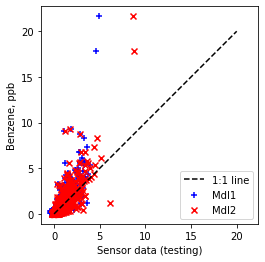

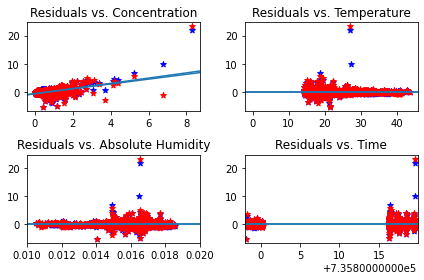

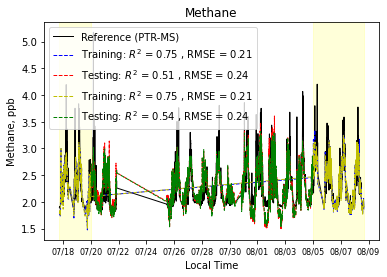

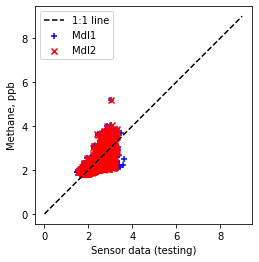

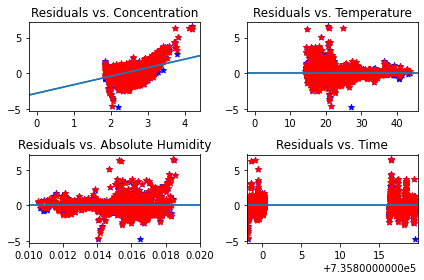

In [19]:
mdl_b, mdl_b1 = linear_fit("Benz", residuals_paper=False) # Benzene Fit
mdl_m, mdl_m1 = linear_fit("CH4")  # Methane Fit

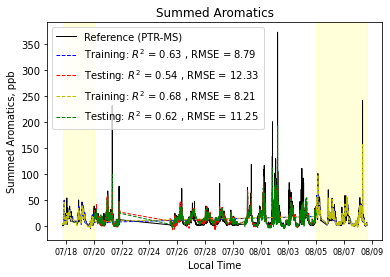

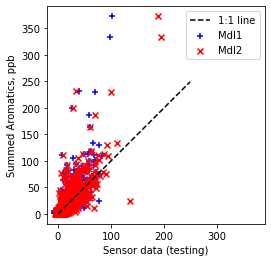

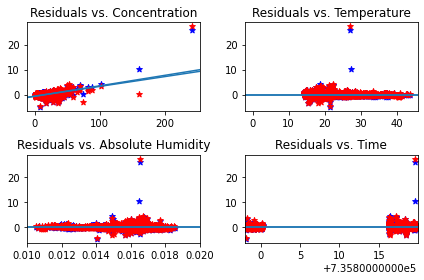

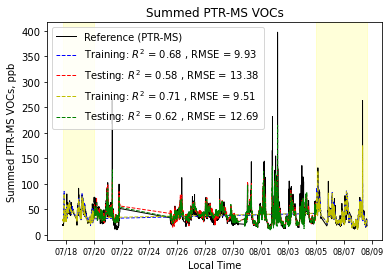

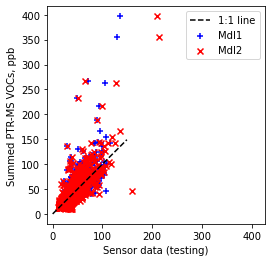

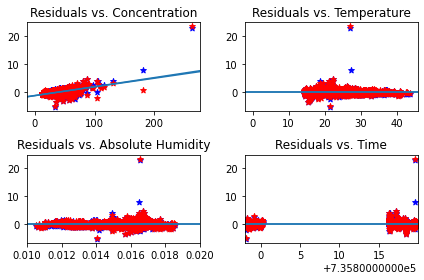

In [6]:
mdl_a, mdl_a1 = linear_fit("Aro")  # Aromatics Fit
mdl_v, mdl_v1 = linear_fit("VOC")  # VOC's Fit

## Iterative Fitting from paper

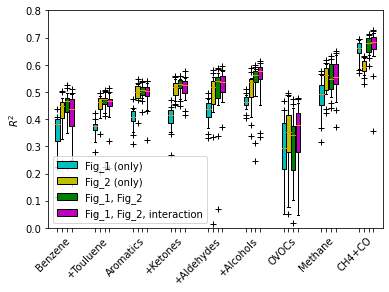

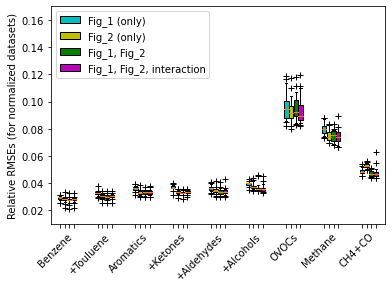

In [7]:
# Create the expected Sums
Sums_exp = np.zeros([len(PrimaryUPod), 9])
Sums_exp[:,0] = 6 * get_column(PrimaryUPod, labels, 'Benz')
Sums_exp[:,1] = Sums_exp[:,0] + 7 * get_column(PrimaryUPod, labels, 'Tol')
Sums_exp[:,2] = Sums_exp[:,1] + 8 * get_column(PrimaryUPod, labels, 'C8') + 9 * get_column(PrimaryUPod, labels, 'C9')
Sums_exp[:,3] = Sums_exp[:,2] + 3 * get_column(PrimaryUPod, labels, 'Acet')
Sums_exp[:,4] = Sums_exp[:,3] + 2 * get_column(PrimaryUPod, labels, 'Actd') + get_column(PrimaryUPod, labels, 'Form')
Sums_exp[:,5] = Sums_exp[:,4] + get_column(PrimaryUPod, labels, 'Meth') + 2 * get_column(PrimaryUPod, labels, 'Actd') + get_column(PrimaryUPod, labels, 'Form')
Sums_exp[:,6] = get_column(PrimaryUPod, labels, 'Meth') + 3 * get_column(PrimaryUPod, labels, 'Acet') 
Sums_exp[:,7] = get_column(PrimaryUPod, labels, 'CH4')
Sums_exp[:,8] = Sums_exp[:,7] + 1/1000 * get_column(PrimaryUPod, labels, 'CO')
Sums = (Sums_exp - Sums_exp.min(0)) / (Sums_exp.max(0) - Sums_exp.min(0))

dataset = PrimaryUPod / np.linalg.norm(PrimaryUPod,axis=0) # most likely not the specific normalization in the paper
dataset1= dataset[:, [9, 1, 8, 0]]; # for mdl1
dataset2= dataset[:, [10, 1, 8, 0]]; # for mdl2
dataset3= dataset[:, [9, 10, 1, 8, 0]]; # for mdl3
dataset4= np.append(dataset[:, [9, 10, 1, 8, 0]], (dataset[:, 9] * dataset[:, 8]).reshape(-1,1), 1) # for mdl4
ind_all = range(0, len(PrimaryUPod));

stats_r = []; stats_e = [];
for range2 in range(0,9):
    stats_rt = []; stats_et = [];
    for range1 in range(0,25):
        ind = np.random.permutation(len(PrimaryUPod)-40)[0:18];
        train = [];
        for ind1 in ind:
            train = train + (list(range(ind1, ind1+40)))
        #train0 = dataset[train]
        
        test_ind = list(set(ind_all) - set(train))  
        
        mdl1 = LinearRegression().fit(dataset1[train], Sums[train, range2])
        mdl2 = LinearRegression().fit(dataset2[train], Sums[train, range2])
        mdl3 = LinearRegression().fit(dataset3[train], Sums[train, range2])
        mdl4 = LinearRegression().fit(dataset4[train], Sums[train, range2])
        
        r = []; e = [];
        r.append(mdl1.score(dataset1[test_ind], Sums[test_ind, range2])); 
        fit1 = mdl1.predict(dataset1[test_ind]);
        e.append(mean_squared_error(fit1, Sums[test_ind, range2], squared=False));
        
        r.append(mdl2.score(dataset2[test_ind], Sums[test_ind, range2])); 
        fit2 = mdl2.predict(dataset2[test_ind]);
        e.append(mean_squared_error(fit2, Sums[test_ind, range2], squared=False));
        
        r.append(mdl3.score(dataset3[test_ind], Sums[test_ind, range2])); 
        fit3 = mdl3.predict(dataset3[test_ind]);
        e.append(mean_squared_error(fit3, Sums[test_ind, range2], squared=False));
        
        r.append(mdl4.score(dataset4[test_ind], Sums[test_ind, range2])); 
        fit4 = mdl4.predict(dataset4[test_ind]);
        e.append(mean_squared_error(fit4, Sums[test_ind, range2], squared=False));
        stats_rt.append(r); stats_et.append(e);
    stats_r.append(stats_rt); stats_e.append(stats_et);

# and now the plots
positions = [1,1.25,1.5,1.75,3,3.25,3.5,3.75,5,5.25,5.5,5.75,7,7.25,7.5,7.75,9,9.25,9.5,9.75,11,11.25,11.5,11.75,13,13.25,13.5,13.75,15,15.25,15.5,15.75,17,17.25,17.5,17.75]
pos_labels = ["","","","Benzene","","","","+Touluene","","","","Aromatics","","","","+Ketones","","","","+Aldehydes","","","","+Alcohols","","","","OVOCs","","","","Methane","","","","CH4+CO"]
colors = ['c','y','g','m','c','y','g','m','c','y','g','m','c','y','g','m','c','y','g','m','c','y','g','m','c','y','g','m','c','y','g','m','c','y','g','m'];
stats_rd = np.array(stats_r)
stats_rd = np.transpose(stats_rd, (1,0,2))
stats_rd = stats_rd.reshape(-1,stats_rd.shape[1] * stats_rd.shape[2])
stats_ed = np.array(stats_e)
stats_ed = np.transpose(stats_ed, (1,0,2))
stats_ed = stats_ed.reshape(-1,stats_ed.shape[1] * stats_ed.shape[2])

fig, ax = plt.subplots()
ax.set_ylabel('$R^2$')
bplot = ax.boxplot(stats_rd, positions=positions, widths=0.24, whis=(5,95), sym="+", patch_artist=True);

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color);
ax.set_xticklabels(pos_labels)
plt.xticks(rotation=45, ha="right")
#plt.legend(["Fig_1 (only)", "Fig_2 (only)", "Fig_1, Fig_2", "Fig_1, Fig_2, interaction"])
ax.legend([bplot['boxes'][0],bplot['boxes'][1],bplot['boxes'][2],bplot['boxes'][3]], ["Fig_1 (only)", "Fig_2 (only)", "Fig_1, Fig_2", "Fig_1, Fig_2, interaction"], loc='lower left')
plt.ylim(0,0.8)
plt.show()

fig, ax = plt.subplots()
ax.set_ylabel('Relative RMSEs (for normalized datasets)')
bplot = ax.boxplot(stats_ed, positions=positions, widths=0.24, whis=(5,95), sym="+", patch_artist=True);

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color);
ax.set_xticklabels(pos_labels)
plt.xticks(rotation=45, ha="right")
#plt.legend(["Fig_1 (only)", "Fig_2 (only)", "Fig_1, Fig_2", "Fig_1, Fig_2, interaction"])
ax.legend([bplot['boxes'][0],bplot['boxes'][1],bplot['boxes'][2],bplot['boxes'][3]], ["Fig_1 (only)", "Fig_2 (only)", "Fig_1, Fig_2", "Fig_1, Fig_2, interaction"], loc='upper left')
plt.ylim(0.01,0.17)
plt.show()

## My Models Improved

### First a Sanity Check for PyTorch
Converting all the data from numpy into pytorch, as well as the model into a linear layer.

In [14]:
# need to rerun because the training was changed due to random iteration
# and need to convert numpy into torch

# prepare the data for the regression
p_TimeL = get_column(PrimaryUPod, labels, 'TimeL')

# defining testing and training data
beg_testing = date.toordinal(date(2014,7,20))+366 # 366 needed to match with MATLAB times
end_testing = date.toordinal(date(2014,8,5))+366
ind1   = sum(p_TimeL <= beg_testing) # use sum to find last as 'True' == 1
ind2   = sum(p_TimeL <= end_testing)
ind1_1 = range(0, ind1)    # or use [:ind1]
ind1_2 = range(ind2, 4822) # or use [ind2:]
train  = list(ind1_1) + list(ind1_2) # for concatenation needs to be in list
test2  = range(ind1, ind2) 

# create the data bactches
x_data   = np.array([PrimaryUPod[:,9], PrimaryUPod[:,10] , PrimaryUPod[:,9] * PrimaryUPod[:,10], PrimaryUPod[:,1], PrimaryUPod[:,8], PrimaryUPod[:,0]]).T
x_train  = x_data[train,:]
x_test   = x_data[test2,:]

x_data2  = np.array([PrimaryUPod[:,9], PrimaryUPod[:,10] , PrimaryUPod[:,9] * PrimaryUPod[:,10], np.square(PrimaryUPod[:,4]), PrimaryUPod[:,1], PrimaryUPod[:,8], PrimaryUPod[:,1] * PrimaryUPod[:,10], PrimaryUPod[:,0]]).T
x_train2 = x_data2[train,:]
x_test2  = x_data2[test2,:]

# data for the aromatics and VOC which are a combination of others
aromatic = 6 * get_column(PrimaryUPod, labels, 'Benz') + 7 * get_column(PrimaryUPod, labels, 'Tol') + 8 * get_column(PrimaryUPod, labels, 'C8') + 9 * get_column(PrimaryUPod, labels, 'C9');
VOC = 6 * get_column(PrimaryUPod, labels, 'Benz') + 7 * get_column(PrimaryUPod, labels, 'Tol') + 8 * get_column(PrimaryUPod, labels, 'C8') + 9 * get_column(PrimaryUPod, labels, 'C9') + get_column(PrimaryUPod, labels, 'Meth') + 3 * get_column(PrimaryUPod, labels, 'Acet') + 2 * get_column(PrimaryUPod, labels, 'Actd') + get_column(PrimaryUPod, labels, 'Form');

# create lists for storing errors
stats_rc = []
stats_ec = []

# to torch now
xx_data = x_data
xx_data = torch.from_numpy(xx_data)
xx_data2 = x_data2
xx_data2 = torch.from_numpy(xx_data2)
xx_train = x_train
xx_train = torch.from_numpy(xx_train)# .float().to(device)
benz_ref = get_column(PrimaryUPod, labels, 'Benz')
benz_train = get_column(PrimaryUPod, labels, 'Benz')[train]
benz_test = get_column(PrimaryUPod, labels, 'Benz')[test2]

yy_train = torch.zeros(benz_train.shape[0],4)
yy_train[:,0] = torch.from_numpy(benz_train)#.float()#.to(device)
yy_train[:,1] = torch.from_numpy(get_column(PrimaryUPod, labels, 'CH4')[train])#.float()#.to(device)
yy_train[:,2] = torch.from_numpy(aromatic[train])#.float()#.to(device)
yy_train[:,3] = torch.from_numpy(VOC[train])#.float()#.to(device)

The weights for the linear fitting of benzene are:
[-8.55752887e+00 -1.08593536e+01  1.06421778e+01 -4.11945902e-02
  1.26142801e+01 -9.34660368e-03] 
 and the bias is 6887.3387794769


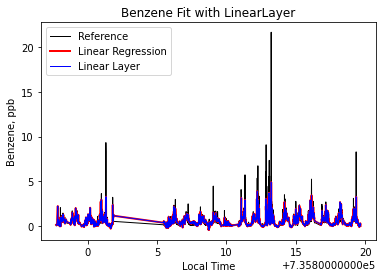

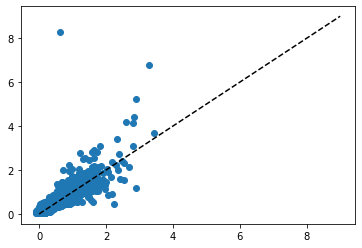

The R^2 value is 0.6752731869473751


In [9]:
# linear fit weights for benzene
print(f'The weights for the linear fitting of benzene are:\n{mdl_b.coef_} \n and the bias is {mdl_b.intercept_}')

# copy the linear regression to verify that it works
model_linear = nn.Linear(xx_train.shape[1],1).double()
with torch.no_grad():
    model_linear.weight[0] = torch.from_numpy(mdl_b.coef_)
    model_linear.bias[0] = torch.from_numpy(np.array(mdl_b.intercept_ ))

y_predw = model_linear(xx_data)

fit_pred = mdl_b.predict(x_data)
reference = get_column(PrimaryUPod, labels, "Benz")
plt.plot(p_TimeL, reference, 'k', linewidth=1)
plt.plot(p_TimeL, fit_pred, 'r', linewidth=2)
plt.plot(p_TimeL, y_predw.detach().numpy(), 'b', linewidth=1)
plt.title('Benzene Fit with LinearLayer');
plt.xlabel('Local Time');
plt.ylabel('Benzene' + ', ppb');
plt.legend(['Reference', 'Linear Regression', 'Linear Layer'])
plt.show()
    
y_pred, y_true = model_linear(xx_train) , yy_train[:,0]
plt.scatter( y_pred.detach().numpy(), y_true.detach().numpy())
plt.plot(range(0,10),range(0,10), '--k')
plt.yscale('linear')
plt.show()

mdl_score = LinearRegression().fit(y_pred.detach().numpy(), y_true.detach().numpy())
print(f'The R^2 value is {mdl_score.score(y_pred.detach().numpy(), y_true.detach().numpy())}')

### One Linear Layer for all the models
As the models all have the same dimensions we can just use one linear layer with N output features in order to run all the models at once, which would likely be the preferrable option to use in real life.

I will do this for both types of models that were fitted and then save the weights, so that others can easily access it.

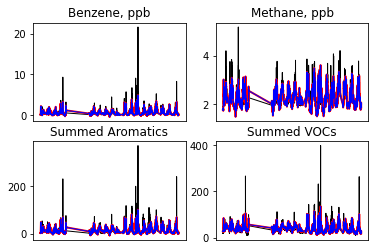

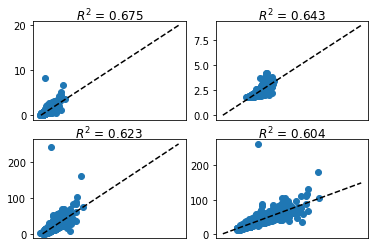

<All keys matched successfully>

In [10]:
linear_all = nn.Linear(xx_train.shape[1],4).double()
with torch.no_grad():
    linear_all.weight[0] = torch.from_numpy(mdl_b.coef_)
    linear_all.bias[0] = torch.from_numpy(np.array(mdl_b.intercept_ ))
    linear_all.weight[1] = torch.from_numpy(mdl_m.coef_)
    linear_all.bias[1] = torch.from_numpy(np.array(mdl_m.intercept_ ))
    linear_all.weight[2] = torch.from_numpy(mdl_a.coef_)
    linear_all.bias[2] = torch.from_numpy(np.array(mdl_a.intercept_ ))
    linear_all.weight[3] = torch.from_numpy(mdl_v.coef_)
    linear_all.bias[3] = torch.from_numpy(np.array(mdl_v.intercept_ ))

y_predw = linear_all(xx_data)

title = ["Benzene, ppb", "Methane, ppb", "Summed Aromatics", "Summed VOCs"]

for idx in range(4):
    # get the references for the model
    if idx == 0:
        reference = get_column(PrimaryUPod, labels, "Benz")
        fit_pred = mdl_b.predict(x_data)
    elif idx == 1:
        reference = get_column(PrimaryUPod, labels, "CH4")
        fit_pred = mdl_m.predict(x_data)
    elif idx == 2:
        reference = aromatic
        fit_pred = mdl_a.predict(x_data)
    elif idx == 3:
        reference = VOC
        fit_pred = mdl_v.predict(x_data)
        
    ax1 = plt.subplot(221+idx)
        
    ax1.plot(p_TimeL, reference, 'k', linewidth=1)
    ax1.plot(p_TimeL, fit_pred, 'r', linewidth=2)
    ax1.plot(p_TimeL, y_predw[:,idx].detach().numpy(), 'b', linewidth=1)
    ax1.set_title(title[idx]);
    #ax1.set_xlabel('Local Time');
    #ax1.set_ylabel('Benzene' + ', ppb');
    #ax1.legend(['Reference', 'Linear Regression', 'Linear Layer'])
    plt.tick_params(bottom = False, labelbottom = False) 
plt.show()

plt_ur = [21,10,250,150]
for idx in range(4):
    y_pred, y_true = linear_all(xx_train) , yy_train[:,idx]
    mdl_score = LinearRegression().fit(y_pred[:,0].reshape(-1, 1).detach().numpy(), y_true.detach().numpy())
    R_2 = mdl_score.score(y_pred[:,0].reshape(-1, 1).detach().numpy(), y_true.detach().numpy())
    
    ax1 = plt.subplot(221+idx)
    ax1.scatter(y_pred[:,idx].detach().numpy(), y_true.detach().numpy())
    ax1.set_title('$R^2$ = {0:.3f}'.format(R_2), pad=1);
    ax1.plot(range(0,plt_ur[idx]),range(0,plt_ur[idx]), '--k')
    plt.tick_params(bottom = False, labelbottom = False) 
    #ax1.yscale('linear')
    #print('The $R^2$ value is {mdl_score.score(y_pred[:,0].reshape(-1, 1).detach().numpy(), y_true.detach().numpy())}')
plt.show()

# save the model
torch.save(linear_all.state_dict(), "./data/linear_mdl0.pt")
# model can latter be recovered like this:
linear_all.load_state_dict(torch.load("./data/linear_mdl0.pt"))

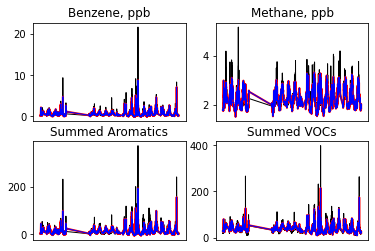

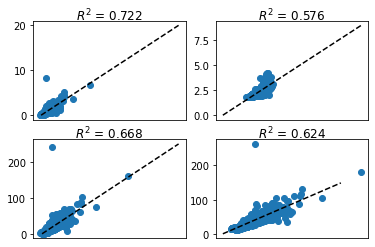

<All keys matched successfully>

In [11]:
linear_all1 = nn.Linear(xx_data2.shape[1],4).double()
with torch.no_grad():
    linear_all1.weight[0] = torch.from_numpy(mdl_b1.coef_)
    linear_all1.bias[0] = torch.from_numpy(np.array(mdl_b1.intercept_ ))
    linear_all1.weight[1] = torch.from_numpy(mdl_m1.coef_)
    linear_all1.bias[1] = torch.from_numpy(np.array(mdl_m1.intercept_ ))
    linear_all1.weight[2] = torch.from_numpy(mdl_a1.coef_)
    linear_all1.bias[2] = torch.from_numpy(np.array(mdl_a1.intercept_ ))
    linear_all1.weight[3] = torch.from_numpy(mdl_v1.coef_)
    linear_all1.bias[3] = torch.from_numpy(np.array(mdl_v1.intercept_ ))

y_predw = linear_all1(xx_data2)

title = ["Benzene, ppb", "Methane, ppb", "Summed Aromatics", "Summed VOCs"]

for idx in range(4):
    # get the references for the model
    if idx == 0:
        reference = get_column(PrimaryUPod, labels, "Benz")
        fit_pred = mdl_b1.predict(x_data2)
    elif idx == 1:
        reference = get_column(PrimaryUPod, labels, "CH4")
        fit_pred = mdl_m1.predict(x_data2)
    elif idx == 2:
        reference = aromatic
        fit_pred = mdl_a1.predict(x_data2)
    elif idx == 3:
        reference = VOC
        fit_pred = mdl_v1.predict(x_data2)
        
    ax1 = plt.subplot(221+idx)
        
    ax1.plot(p_TimeL, reference, 'k', linewidth=1)
    ax1.plot(p_TimeL, fit_pred, 'r', linewidth=2)
    ax1.plot(p_TimeL, y_predw[:,idx].detach().numpy(), 'b', linewidth=1)
    ax1.set_title(title[idx]);
    #ax1.set_xlabel('Local Time');
    #ax1.set_ylabel('Benzene' + ', ppb');
    #ax1.legend(['Reference', 'Linear Regression', 'Linear Layer'])
    plt.tick_params(bottom = False, labelbottom = False) 
plt.show()

plt_ur = [21,10,250,150]
for idx in range(4):
    y_pred, y_true = linear_all1(xx_data2[train]) , yy_train[:,idx]
    mdl_score = LinearRegression().fit(y_pred[:,0].reshape(-1, 1).detach().numpy(), y_true.detach().numpy())
    R_2 = mdl_score.score(y_pred[:,0].reshape(-1, 1).detach().numpy(), y_true.detach().numpy())
    
    ax1 = plt.subplot(221+idx)
    ax1.scatter(y_pred[:,idx].detach().numpy(), y_true.detach().numpy())
    ax1.set_title('$R^2$ = {0:.3f}'.format(R_2), pad=1);
    ax1.plot(range(0,plt_ur[idx]),range(0,plt_ur[idx]), '--k')
    plt.tick_params(bottom = False, labelbottom = False) 
    #ax1.yscale('linear')
    #print('The $R^2$ value is {mdl_score.score(y_pred[:,0].reshape(-1, 1).detach().numpy(), y_true.detach().numpy())}')
plt.show()

# save the model
torch.save(linear_all1.state_dict(), "./data/linear_mdl1.pt")
# model can latter be recovered like this:
linear_all1.load_state_dict(torch.load("./data/linear_mdl1.pt"))

### Creating a Neural Network

### Train a model for each individually

In [13]:
class NeuralNet(nn.Module):
    # Neural network with one hidden layer
    def __init__(self, linear_dim=[64,1], name="NN_model", activation=nn.ReLU()):
        super(NeuralNet, self).__init__()   
        self.linlayers = nn.ModuleList([nn.Linear(linear_dim[i], linear_dim[i+1]) for i in range(len(linear_dim)-1)])
        self.act = activation
        self.name = name

    def forward(self, x):        
        for idx in range(len(self.linlayers)-1):
            x = self.act(self.linlayers[idx](x))
        y = self.linlayers[-1](x)
        return y
    
def score(y_true, y_pred):
    u = (y_true - y_pred).square().sum()
    v = ((y_true - y_true.mean()).square()).sum()
    return 1 - u/v # equation doesnt seem to work
    

def train_NN(model, data, target, optimizer, criterion, file_s=None, batch_size=None, n_epoch=30):
    # if the model already exists try to load it
    if file_s is None:
        file_s = "./data/" + model.name + ".pt"
    try:
      model.load_state_dict(torch.load(file_s))
    except IOError:
      print("Model not saved before, training from scratch")
    
    # set the min_loss for saving the model
    output = model(data)
    min_loss = criterion(output, target).item()
    
    # training and evaluation
    losses_train = []
    errs_train = []
    losses_test = []
    errs_test = []
    train_data = data
    for ep in range(n_epoch):
        #model.train()
        optimizer.zero_grad()
        
        # if we want to create random batches to use in training
        if batch_size is not None:
            batch_idx = torch.randint(data.shape[0], (batch_size,))
            train_data = data[batch_idx]
        
        # forward the data to the model and get the output
        output = model(train_data)
        
        loss = criterion(output, target)
        
        # if the loss is better than before save the model
        if loss < min_loss:
            min_loss = loss.item()
            #print("Better model now has loss of {}".format(min_loss))
            torch.save(model.state_dict(), file_s)
        
        # backward (PyTorch computes backpropagation for you)
        loss.backward()
        optimizer.step()
        
        losses_train.append(loss.item())

        if int(ep % (n_epoch/10)) == 0:
            #t_lr = optimizer.param_groups[0]['lr']
            print(f'[{ep}]\tloss_train: {loss:.4f}')#\tlr: {t_lr}')

    # plot the training/testing loss and accuracy
    plt.semilogy(np.arange(n_epoch), losses_train, color='b', label='train_loss')
    plt.title("Loss while training")
    
    # reload the model with the best performing weights
    model.load_state_dict(torch.load(file_s))
    return losses_train

Model not saved before, training from scratch
[0]	loss_train: 2.4036
[10]	loss_train: 2.0559
[20]	loss_train: 1.5380
[30]	loss_train: 1.1273
[40]	loss_train: 0.8578
[50]	loss_train: 0.6983
[60]	loss_train: 0.6078
[70]	loss_train: 0.5572
[80]	loss_train: 0.5289
[90]	loss_train: 0.5130


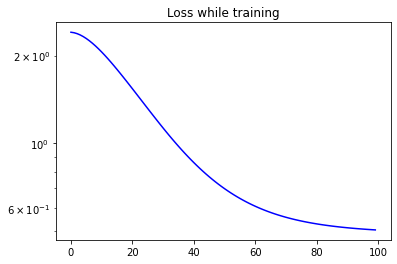

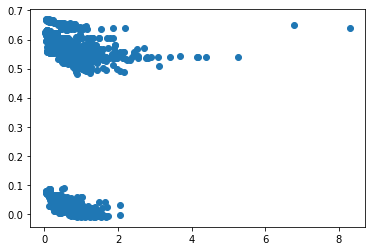

The R^2 value is 1.5994767732507853e-09


In [64]:
linear_dim = [xx_train.shape[1], 16, 16, 1]
initial_model = NeuralNet(linear_dim, "initial_model").double()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(initial_model.parameters(), lr=0.00001, weight_decay=1, momentum=0.9)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay= 0.9)

# try to train a model normally for benz
losses_train_init = train_NN(initial_model, xx_train, yy_train[:,0].reshape(-1,1), optimizer, criterion, n_epoch= 100)

# show results more concretely
y_pred, y_true = initial_model(xx_train) , yy_train[:,0]
plt.figure()
plt.scatter(y_true.detach().numpy(), y_pred.detach().numpy())
#plt.plot(range(0,11),range(0,11), '--k')
plt.show()
mdl_score = LinearRegression().fit(y_pred.detach().numpy(), y_true.detach().numpy())
print(f'The R^2 value is {mdl_score.score(y_pred.detach().numpy(), y_true.detach().numpy())}')

Model not saved before, training from scratch
[0]	loss_train: 1.0789
[10]	loss_train: 0.4559
[20]	loss_train: 0.4489
[30]	loss_train: 0.4435
[40]	loss_train: 0.4385
[50]	loss_train: 0.4337
[60]	loss_train: 0.4294
[70]	loss_train: 0.4256
[80]	loss_train: 0.4222
[90]	loss_train: 0.4192


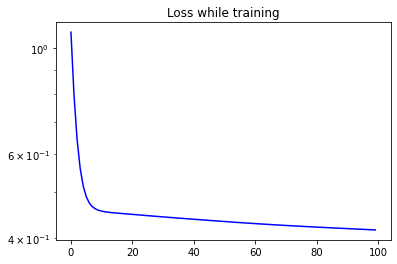

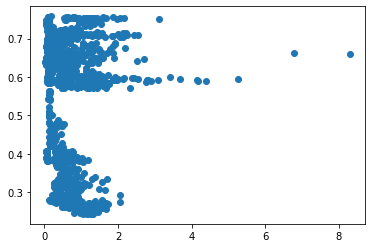

The R^2 value is 0.0007201276106403309


In [65]:
xx_train_n = x_train
xx_train_n[:,-1] = xx_train_n[:,-1] - xx_train_n[:,-1].min()#/ np.linalg.norm(xx_train[:,-1],axis=0)
xx_train_n = torch.from_numpy(xx_train_n)# .float().to(device)
benz_train = get_column(PrimaryUPod, labels, 'Benz')[train]
benz_test = get_column(PrimaryUPod, labels, 'Benz')[test2]

linear_dim = [xx_train_n.shape[1], 16, 16, 1]
norm_model = NeuralNet(linear_dim, "norm_model").double()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(norm_model.parameters(), lr=0.001, weight_decay=0.)#, momentum=0.9)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay= 0.9)

# try to train a model normally
losses_train_n = train_NN(norm_model, xx_train_n, yy_train[:,0].reshape(-1,1), optimizer, criterion, n_epoch= 100)

# show results more concretely
y_pred, y_true = norm_model(xx_train_n) , yy_train[:,0]
plt.figure()
plt.scatter(y_true.detach().numpy(), y_pred.detach().numpy())
#plt.plot(range(0,11),range(0,11), '--k')
plt.show()
mdl_score = LinearRegression().fit(y_pred.detach().numpy(), y_true.detach().numpy())
print(f'The R^2 value is {mdl_score.score(y_pred.detach().numpy(), y_true.detach().numpy())}')

Model not saved before, training from scratch
[0]	loss_train: 0.5878
[10]	loss_train: 0.4943
[20]	loss_train: 0.4821
[30]	loss_train: 0.4741
[40]	loss_train: 0.4665
[50]	loss_train: 0.4592
[60]	loss_train: 0.4522
[70]	loss_train: 0.4455
[80]	loss_train: 0.4391
[90]	loss_train: 0.4329


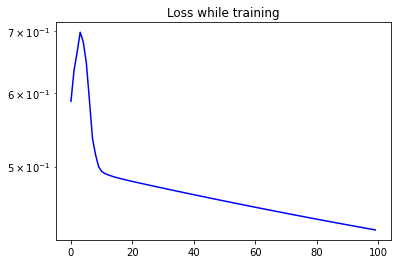

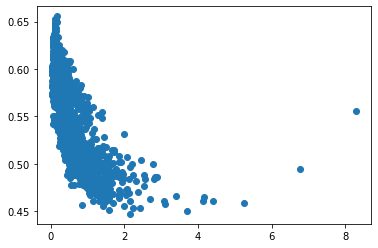

The R^2 value is 0.4189901200687365


In [66]:
linear_dim = [xx_train.shape[1]-1, 16, 16, 1]
timeless_model = NeuralNet(linear_dim,'timeless_model').double()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(timeless_model.parameters(), lr=0.01, weight_decay=0.)#, momentum=0.9)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay= 0.9)

# try to train a model normally
losses_train_t = train_NN(timeless_model, xx_train[:,:-1], yy_train[:,0].reshape(-1,1), optimizer, criterion, n_epoch= 100)

# show results more concretely
y_pred, y_true = timeless_model(xx_train[:,:-1]) , yy_train[:,0]
plt.figure()
plt.scatter(y_true.detach().numpy(), y_pred.detach().numpy())
#plt.plot(range(0,plt_ur[0]),range(0,11), '--k')
plt.show()
mdl_score = LinearRegression().fit(y_pred.detach().numpy(), y_true.detach().numpy())
print(f'The R^2 value is {mdl_score.score(y_pred.detach().numpy(), y_true.detach().numpy())}')

Model not saved before, training from scratch
[0]	loss_train: 0.5147
[10]	loss_train: 0.3849
[20]	loss_train: 0.3716
[30]	loss_train: 0.3699
[40]	loss_train: 0.3694
[50]	loss_train: 0.3691
[60]	loss_train: 0.3687
[70]	loss_train: 0.3684
[80]	loss_train: 0.3680
[90]	loss_train: 0.3677


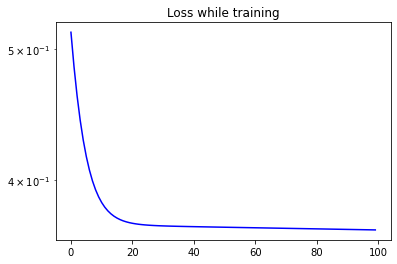

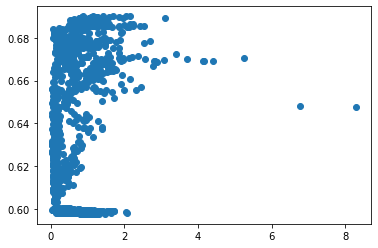

The R^2 value is 0.09350218970635282


In [78]:
linear_dim = [xx_train.shape[1], 16, 16, 1]
sigmoid_model = NeuralNet(linear_dim,'sigmoid_model', nn.Sigmoid()).double()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(sigmoid_model.parameters(), lr=0.01, weight_decay=0.)#, momentum=0.9)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay= 0.9)

# try to train a model normally
losses_train_s = train_NN(sigmoid_model, xx_train, yy_train[:,0].reshape(-1,1), optimizer, criterion, n_epoch= 100)

# show results more concretely
y_pred, y_true = sigmoid_model(xx_train) , yy_train[:,0]
plt.figure()
plt.scatter(y_true.detach().numpy(), y_pred.detach().numpy())
#plt.plot(range(0,plt_ur[0]),range(0,11), '--k')
plt.show()
mdl_score = LinearRegression().fit(y_pred.detach().numpy(), y_true.detach().numpy())
print(f'The R^2 value is {mdl_score.score(y_pred.detach().numpy(), y_true.detach().numpy())}')

Model not saved before, training from scratch
[0]	loss_train: 0.5567
[10]	loss_train: 0.3171
[20]	loss_train: 0.2455
[30]	loss_train: 0.2057
[40]	loss_train: 0.1794
[50]	loss_train: 0.1647
[60]	loss_train: 0.1560
[70]	loss_train: 0.1507
[80]	loss_train: 0.1476
[90]	loss_train: 0.1457


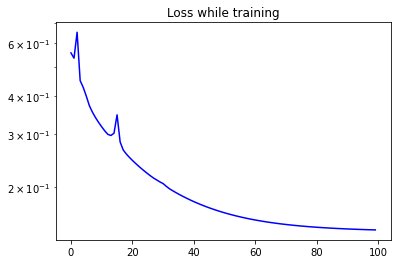

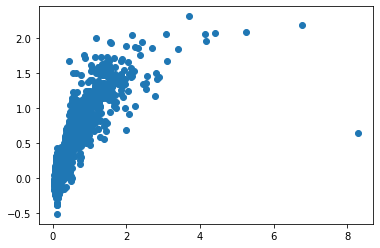

The R^2 value is 0.6227537233105849


In [127]:
linear_dim = [xx_train.shape[1]-1, 16, 16, 1]
bnorm_model = NeuralNet(linear_dim,'bnorm_model', nn.BatchNorm1d(16)).double()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(bnorm_model.parameters(), lr=0.01, weight_decay=0.)#, momentum=0.9)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay= 0.9)

# try to train a model normally
losses_train_bn = train_NN(bnorm_model, xx_train[:,:-1], yy_train[:,0].reshape(-1,1), optimizer, criterion, n_epoch= 100)

# show results more concretely
y_pred, y_true = bnorm_model(xx_train[:,:-1]) , yy_train[:,0]
plt.figure()
plt.scatter(y_true.detach().numpy(), y_pred.detach().numpy())
#plt.plot(range(0,plt_ur[0]),range(0,11), '--k')
plt.show()
mdl_score = LinearRegression().fit(y_pred.detach().numpy(), y_true.detach().numpy())
print(f'The R^2 value is {mdl_score.score(y_pred.detach().numpy(), y_true.detach().numpy())}')

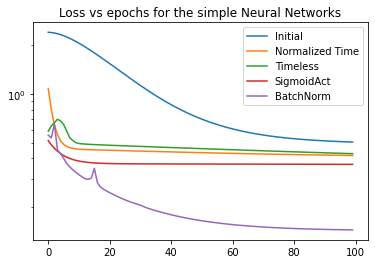

In [128]:
plt.semilogy(np.arange(len(losses_train_init)), losses_train_init, label='Initial')
plt.semilogy(np.arange(len(losses_train_n)), losses_train_n, label='Normalized Time')
plt.semilogy(np.arange(len(losses_train_t)), losses_train_t, label='Timeless')
plt.semilogy(np.arange(len(losses_train_s)), losses_train_s, label='SigmoidAct')
plt.semilogy(np.arange(len(losses_train_bn)), losses_train_bn, label='BatchNorm')
plt.legend()
plt.title("Loss vs epochs for the simple Neural Networks")
plt.show()

[0]	loss_train: 0.1446
[10]	loss_train: 0.1446
[20]	loss_train: 0.1445
[30]	loss_train: 0.1444
[40]	loss_train: 0.1444
[50]	loss_train: 0.1443
[60]	loss_train: 0.1442
[70]	loss_train: 0.1441
[80]	loss_train: 0.1441
[90]	loss_train: 0.1440


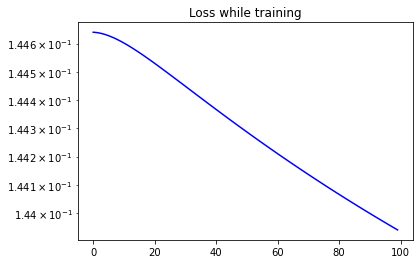

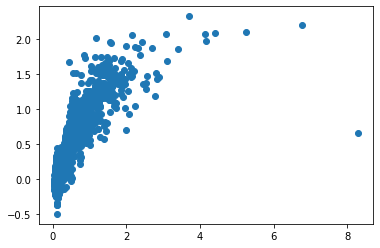

The R^2 value is 0.6229956241206673


In [129]:
# as the model with batch normalization is the only one that performs okay, 
# I will let it train for longer, and see how far it can go alone like this
optimizer = torch.optim.SGD(bnorm_model.parameters(), lr=0.0001, weight_decay=0., momentum=0.9)
losses_train_bn_long = train_NN(bnorm_model, xx_train[:,:-1], yy_train[:,0].reshape(-1,1), optimizer, criterion, n_epoch= 100)

# show results more concretely
y_pred, y_true = bnorm_model(xx_train[:,:-1]) , yy_train[:,0]
plt.figure()
plt.scatter(y_true.detach().numpy(), y_pred.detach().numpy())
#plt.plot(range(0,plt_ur[0]),range(0,11), '--k')
plt.show()
mdl_score = LinearRegression().fit(y_pred.detach().numpy(), y_true.detach().numpy())
print(f'The R^2 value is {mdl_score.score(y_pred.detach().numpy(), y_true.detach().numpy())}')

The above models use the data that fits Model1, now I will try to fit with the data for Model2.

[0]	loss_train: 0.1189
[10]	loss_train: 0.1189
[20]	loss_train: 0.1188
[30]	loss_train: 0.1187
[40]	loss_train: 0.1187
[50]	loss_train: 0.1186
[60]	loss_train: 0.1185
[70]	loss_train: 0.1184
[80]	loss_train: 0.1182
[90]	loss_train: 0.1181


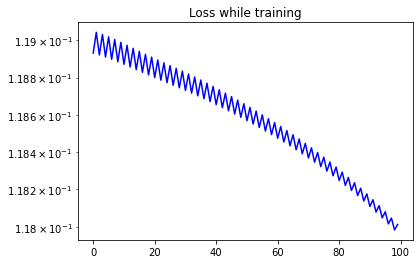

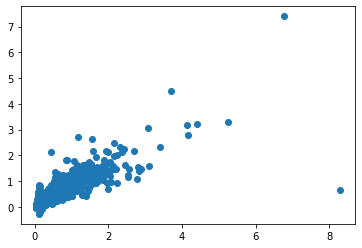

The R^2 value is 0.6893312425175036


In [38]:
xx_train2 = xx_data2[train] # use dataset 2, with time just to confirm
linear_dim = [xx_train2.shape[1], 16, 16, 1]
bnorm_model2 = NeuralNet(linear_dim,'bnorm_model2', nn.BatchNorm1d(16)).double()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(bnorm_model2.parameters(), lr=0.01, weight_decay=0.)#, momentum=0.9)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay= 0.9)

# try to train a model normally
losses_train_bn = train_NN(bnorm_model2, xx_train2, yy_train[:,0].reshape(-1,1), optimizer, criterion, n_epoch= 100)

# show results more concretely
y_pred, y_true = bnorm_model2(xx_train2) , yy_train[:,0]
plt.figure()
plt.scatter(y_true.detach().numpy(), y_pred.detach().numpy())
#plt.plot(range(0,plt_ur[0]),range(0,11), '--k')
plt.show()
mdl_score = LinearRegression().fit(y_pred.detach().numpy(), y_true.detach().numpy())
print(f'The R^2 value is {mdl_score.score(y_pred.detach().numpy(), y_true.detach().numpy())}')

[0]	loss_train: 0.1229
[10]	loss_train: 0.1263
[20]	loss_train: 0.1261
[30]	loss_train: 0.1260
[40]	loss_train: 0.1260
[50]	loss_train: 0.1260
[60]	loss_train: 0.1260
[70]	loss_train: 0.1260
[80]	loss_train: 0.1259
[90]	loss_train: 0.1259


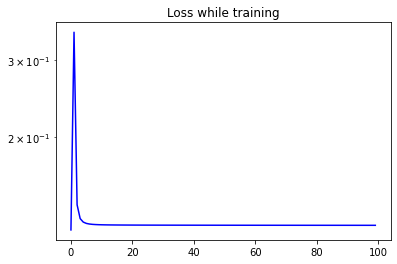

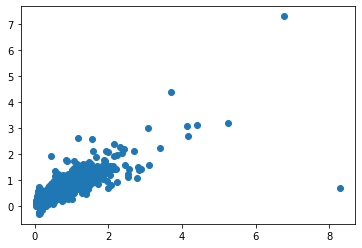

The R^2 value is 0.6804776154645992


In [37]:
xx_train2 = xx_data2[train,:-1] # use dataset 2, and remove time
linear_dim = [xx_train2.shape[1], 16, 16, 1]
bnormt_model2 = NeuralNet(linear_dim,'bnormt_model2', nn.BatchNorm1d(16)).double()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(bnormt_model2.parameters(), lr=0.01, weight_decay=0.)#, momentum=0.9)
#optimizer = torch.optim.Adagrad(bnormt_model2.parameters(), lr=0.01, lr_decay= 0.9)

# try to train a model normally
losses_train_bn = train_NN(bnormt_model2, xx_train2, yy_train[:,0].reshape(-1,1), optimizer, criterion, n_epoch= 100)

# show results more concretely
y_pred, y_true = bnormt_model2(xx_train2) , yy_train[:,0]
plt.figure()
plt.scatter(y_true.detach().numpy(), y_pred.detach().numpy())
#plt.plot(range(0,plt_ur[0]),range(0,11), '--k')
plt.show()
mdl_score = LinearRegression().fit(y_pred.detach().numpy(), y_true.detach().numpy())
print(f'The R^2 value is {mdl_score.score(y_pred.detach().numpy(), y_true.detach().numpy())}')

### Train a model for all Sums concurrently

[0]	loss_train: 83.4610
[10]	loss_train: 95.5218
[20]	loss_train: 91.3541
[30]	loss_train: 93.5589
[40]	loss_train: 97.2144
[50]	loss_train: 96.4414
[60]	loss_train: 95.6616
[70]	loss_train: 93.8373
[80]	loss_train: 91.5919
[90]	loss_train: 86.1534


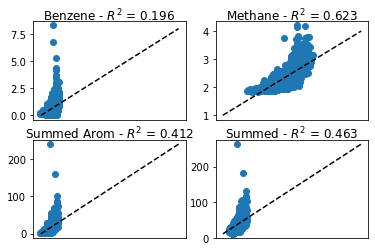

The average R^2 is 0.4236898389818351


In [119]:
linear_dim = [xx_train.shape[1], 16, 16, 4]
bnorm_all_model = NeuralNet(linear_dim,'bnorm_model_all', nn.BatchNorm1d(16)).double()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(bnorm_all_model.parameters(), lr=0.001, weight_decay=0., momentum=0.9)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay= 0.9)

# try to train a model normally
losses_train_bn = train_NN(bnorm_all_model, xx_train, yy_train, optimizer, criterion, n_epoch= 100)

# show results more concretely
y_pred, y_true = bnorm_all_model(xx_train) , yy_train

# show results more concretely
R_avg = 0
for idx in range(4):    
    mdl_score = LinearRegression().fit(y_pred[:,idx].reshape(-1,1).detach().numpy(), y_true[:,idx].reshape(-1,1).detach().numpy())
    R_2 = mdl_score.score(y_pred[:,idx].reshape(-1,1).detach().numpy(), y_true[:,idx].reshape(-1,1).detach().numpy())
    R_avg += R_2/4

    ax1 = plt.subplot(221+idx)
    ax1.scatter(y_pred[:,idx].detach().numpy(), y_true[:,idx].detach().numpy())
    plt_min = int(min(y_pred[:,idx].min().item(), y_true[:,idx].min()))
    plt_max = int(max(y_pred[:,idx].max().item(), y_true[:,idx].max()))+1
    ax1.plot(range(plt_min,plt_max),range(plt_min,plt_max), '--k')
    plt.tick_params(bottom = False, labelbottom = False) 
    ax1.set_title(title[idx][:-5] + ' - $R^2$ = {0:.3f}'.format(R_2), pad=1)
plt.show()

print(f'The average R^2 is {R_avg}')

[0]	loss_train: 56.9432
[10]	loss_train: 53.7345
[20]	loss_train: 53.2973
[30]	loss_train: 52.9807
[40]	loss_train: 52.7888
[50]	loss_train: 52.7413
[60]	loss_train: 52.7133
[70]	loss_train: 52.6883
[80]	loss_train: 52.6661
[90]	loss_train: 52.6449


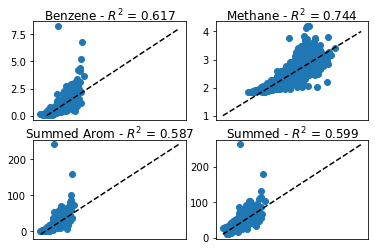

The average R^2 is 0.6366522915745956


In [132]:
linear_dim = [xx_train.shape[1]-1, 16, 16, 4]
bnorm_t_model = NeuralNet(linear_dim,'bnorm_t_model', nn.BatchNorm1d(16)).double()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(bnorm_t_model.parameters(), lr=0.001, weight_decay=0., momentum=0.9)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay= 0.9)

# try to train a model without the time
losses_train_bnt = train_NN(bnorm_t_model, xx_train[:,:-1], yy_train, optimizer, criterion, n_epoch= 100)

# show results more concretely
y_pred, y_true = bnorm_t_model(xx_train[:,:-1]) , yy_train

# show results more concretely
R_avg = 0
for idx in range(4):    
    mdl_score = LinearRegression().fit(y_pred[:,idx].reshape(-1,1).detach().numpy(), y_true[:,idx].reshape(-1,1).detach().numpy())
    R_2 = mdl_score.score(y_pred[:,idx].reshape(-1,1).detach().numpy(), y_true[:,idx].reshape(-1,1).detach().numpy())
    R_avg += R_2/4

    ax1 = plt.subplot(221+idx)
    ax1.scatter(y_pred[:,idx].detach().numpy(), y_true[:,idx].detach().numpy())
    plt_min = int(min(y_pred[:,idx].min().item(), y_true[:,idx].min()))
    plt_max = int(max(y_pred[:,idx].max().item(), y_true[:,idx].max()))+1
    ax1.plot(range(plt_min,plt_max),range(plt_min,plt_max), '--k')
    plt.tick_params(bottom = False, labelbottom = False) 
    ax1.set_title(title[idx][:-5] + ' - $R^2$ = {0:.3f}'.format(R_2), pad=1)
plt.show()

print(f'The average R^2 is {R_avg}')

As we can see above, removing time from the model, greatly helps with the estimation.
While this may be a quirk of the neural network, I still want to confirm for the linear model

In [11]:
# the models perform better without time so what if I remove time from the initial linear fits?
name = "Benz"
y_train = get_column(PrimaryUPod, labels, name)[train]
y_test = get_column(PrimaryUPod, labels, name)[test2]
full_name = full_labels[labels.index(name)]
reference = get_column(PrimaryUPod, labels, name)
    
plt_ur = (int(max(y_test) / 10) + 1) * 10
if  (name == 'Benz'):
    plt_ur = 21;
elif (name == 'CH4'):
    plt_ur = 10;
elif (name == 'Aro'):
    plt_ur = 250;
elif (name == 'VOC'):
    plt_ur = 150;

# still have time in this print
print(f"Model 1 with time achieves R^2 of {r1} and RMSE of {e1}")
print(f"Model 2 with time achieves R^2 of {r3} and RMSE of {e3}")
    
# General Linear Regression Models

mdl = LinearRegression().fit(x_train[:,:-1], y_train)
fitted = mdl.predict(x_train[:,:-1])
predicted = mdl.predict(x_test[:,:-1])
r0 = mdl.score(x_train[:,:-1], y_train)
e0 = mean_squared_error(fitted, y_train, squared=False) # false for getting the RMSE
r1 = mdl.score(x_test[:,:-1], y_test)
e1 = mean_squared_error(predicted, y_test, squared=False)

mdl2 = LinearRegression().fit(x_train2[:,:-1], y_train)
fitted2 = mdl2.predict(x_train2[:,:-1])
predicted2 = mdl2.predict(x_test2[:,:-1])
r2 = mdl2.score(x_train2[:,:-1], y_train)
e2 = mean_squared_error(fitted2, y_train, squared=False)
r3 = mdl2.score(x_test2[:,:-1], y_test)
e3 = mean_squared_error(predicted2, y_test, squared=False)

print(f"Model 1 without time achieves R^2 of {r1} and RMSE of {e1}")
print(f"Model 2 without time achieves R^2 of {r3} and RMSE of {e3}")


Model 1 with time achieves R^2 of 0.5565499231175951 and RMSE of 0.5761128091142976
Model 2 with time achieves R^2 of 0.644910458236752 and RMSE of 0.5155301919750023
Model 1 without time achieves R^2 of 0.5576393877347505 and RMSE of 0.5754046792342977
Model 2 without time achieves R^2 of 0.6483861373770121 and RMSE of 0.5130009372788578


[0]	loss_train: 52.1558
[10]	loss_train: 53.2905
[20]	loss_train: 52.9533
[30]	loss_train: 52.7712
[40]	loss_train: 52.9364
[50]	loss_train: 52.7940
[60]	loss_train: 52.5851
[70]	loss_train: 52.5007
[80]	loss_train: 52.7131
[90]	loss_train: 52.2203


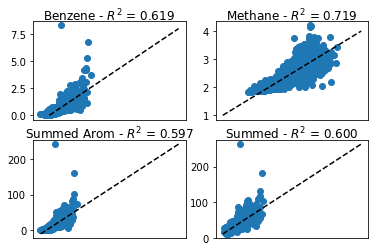

The average R^2 is 0.6338648572719638


In [47]:
linear_dim = [xx_train.shape[1]-1, 64, 64, 64, 4]
bnorm_lt_model = NeuralNet(linear_dim,'bnorm_lt_model', nn.BatchNorm1d(64)).double()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(bnorm_lt_model.parameters(), lr=0.001, weight_decay=0., momentum=0.9)
#optimizer = torch.optim.Adagrad(bnorm_lt_model.parameters(), lr=0.01, lr_decay= 0.9)

# try to train a model without the time
losses_train_bnlt = train_NN(bnorm_lt_model, xx_train[:,:-1], yy_train, optimizer, criterion, n_epoch= 100)

# show results more concretely
y_pred, y_true = bnorm_lt_model(xx_train[:,:-1]) , yy_train

# show results more concretely
R_avg = 0
for idx in range(4):    
    mdl_score = LinearRegression().fit(y_pred[:,idx].reshape(-1,1).detach().numpy(), y_true[:,idx].reshape(-1,1).detach().numpy())
    R_2 = mdl_score.score(y_pred[:,idx].reshape(-1,1).detach().numpy(), y_true[:,idx].reshape(-1,1).detach().numpy())
    R_avg += R_2/4

    ax1 = plt.subplot(221+idx)
    ax1.scatter(y_pred[:,idx].detach().numpy(), y_true[:,idx].detach().numpy())
    plt_min = int(min(y_pred[:,idx].min().item(), y_true[:,idx].min()))
    plt_max = int(max(y_pred[:,idx].max().item(), y_true[:,idx].max()))+1
    ax1.plot(range(plt_min,plt_max),range(plt_min,plt_max), '--k')
    plt.tick_params(bottom = False, labelbottom = False) 
    ax1.set_title(title[idx][:-5] + ' - $R^2$ = {0:.3f}'.format(R_2), pad=1)
plt.show()

print(f'The average R^2 is {R_avg}')

[0]	loss_train: 46.0218
[10]	loss_train: 46.0345
[20]	loss_train: 46.5459
[30]	loss_train: 46.1818
[40]	loss_train: 46.1221
[50]	loss_train: 46.0227
[60]	loss_train: 46.1946
[70]	loss_train: 46.2270
[80]	loss_train: 46.1570
[90]	loss_train: 46.1286


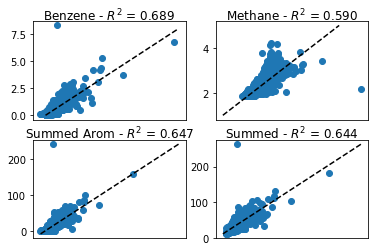

The average R^2 is 0.6424134210073399


In [51]:
xx_train2 = xx_data2[train] # use dataset 2, with time just to confirm
linear_dim = [xx_train2.shape[1], 64, 64, 64, 4]
bnorm_all_model2 = NeuralNet(linear_dim,'bnorm_all_model2', nn.BatchNorm1d(64)).double()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(bnorm_all_model2.parameters(), lr=0.001, weight_decay=0., momentum=0.9)
#optimizer = torch.optim.Adagrad(bnorm_lt_model.parameters(), lr=0.01, lr_decay= 0.9)

# try to train a model without the time
losses_train_bnlt = train_NN(bnorm_all_model2, xx_train2, yy_train, optimizer, criterion, n_epoch= 100)

# show results more concretely
y_pred, y_true = bnorm_all_model2(xx_train2) , yy_train

# show results more concretely
R_avg = 0
for idx in range(4):    
    mdl_score = LinearRegression().fit(y_pred[:,idx].reshape(-1,1).detach().numpy(), y_true[:,idx].reshape(-1,1).detach().numpy())
    R_2 = mdl_score.score(y_pred[:,idx].reshape(-1,1).detach().numpy(), y_true[:,idx].reshape(-1,1).detach().numpy())
    R_avg += R_2/4

    ax1 = plt.subplot(221+idx)
    ax1.scatter(y_pred[:,idx].detach().numpy(), y_true[:,idx].detach().numpy())
    plt_min = int(min(y_pred[:,idx].min().item(), y_true[:,idx].min()))
    plt_max = int(max(y_pred[:,idx].max().item(), y_true[:,idx].max()))+1
    ax1.plot(range(plt_min,plt_max),range(plt_min,plt_max), '--k')
    plt.tick_params(bottom = False, labelbottom = False) 
    ax1.set_title(title[idx][:-5] + ' - $R^2$ = {0:.3f}'.format(R_2), pad=1)
plt.show()

print(f'The average R^2 is {R_avg}')

[0]	loss_train: 54.7349
[10]	loss_train: 54.6585
[20]	loss_train: 54.6074
[30]	loss_train: 54.5731
[40]	loss_train: 54.5534
[50]	loss_train: 54.5346
[60]	loss_train: 54.5151
[70]	loss_train: 54.4948
[80]	loss_train: 54.4739
[90]	loss_train: 54.4524


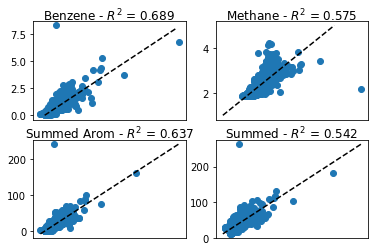

The average R^2 is 0.6106094687515853


In [55]:
xx_train2 = xx_data2[train,:-1] # use dataset 2, with time just to confirm
linear_dim = [xx_train2.shape[1], 64, 64, 64, 4]
bnorm_lt_model2 = NeuralNet(linear_dim,'bnorm_lt_model2', nn.BatchNorm1d(64)).double()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(bnorm_lt_model2.parameters(), lr=0.001, weight_decay=0., momentum=0.9)
#optimizer = torch.optim.Adagrad(bnorm_lt_model.parameters(), lr=0.01, lr_decay= 0.9)

# try to train a model without the time
losses_train_bnlt = train_NN(bnorm_lt_model2, xx_train2, yy_train, optimizer, criterion, n_epoch= 100)

# show results more concretely
y_pred, y_true = bnorm_lt_model2(xx_train2) , yy_train

# show results more concretely
R_avg = 0
for idx in range(4):    
    mdl_score = LinearRegression().fit(y_pred[:,idx].reshape(-1,1).detach().numpy(), y_true[:,idx].reshape(-1,1).detach().numpy())
    R_2 = mdl_score.score(y_pred[:,idx].reshape(-1,1).detach().numpy(), y_true[:,idx].reshape(-1,1).detach().numpy())
    R_avg += R_2/4

    ax1 = plt.subplot(221+idx)
    ax1.scatter(y_pred[:,idx].detach().numpy(), y_true[:,idx].detach().numpy())
    plt_min = int(min(y_pred[:,idx].min().item(), y_true[:,idx].min()))
    plt_max = int(max(y_pred[:,idx].max().item(), y_true[:,idx].max()))+1
    ax1.plot(range(plt_min,plt_max),range(plt_min,plt_max), '--k')
    plt.tick_params(bottom = False, labelbottom = False) 
    ax1.set_title(title[idx][:-5] + ' - $R^2$ = {0:.3f}'.format(R_2), pad=1)
plt.show()

print(f'The average R^2 is {R_avg}')